In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
from openslide import open_slide
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.colors as colors
from torchvision import transforms
import sys
import timm
from torchvision.transforms import InterpolationMode
from PIL import Image
sys.path.append('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/src')
from models.inception_model import InceptionV3

In [2]:
Image.MAX_IMAGE_PIXELS = None

In [3]:
M_darkpurple = '#783CBB'
M_lightpurple = '#A385DB'
# M_green = '#479C8A'
M_green = '#0a888a'
M_yellow = '#FFDD99'
M_lightpink = '#EFA9CD'
M_darkpink = '#E953AD'

colour_list = [M_lightpink, M_green, M_darkpurple, M_darkpink, M_lightpurple, M_yellow]
cd = {'lightpink': M_lightpink, 'lightpurple': M_lightpurple, 'green': M_green, 'purple': M_darkpurple, 'pink': M_darkpink, 'yellow': M_yellow}
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour_list)

In [4]:
# Create custom gradient colourmap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# PURPLE TO YELLOW
rgb_tuples =[(105, 43, 175),(121, 40, 172),(135, 38, 169),(148, 36, 166),(160, 34, 163),
             (171, 33, 159),(181, 33, 156),(190, 35, 152),(199, 37, 148),(207, 41, 144),
             (214, 45, 140),(221, 51, 136),(227, 56, 132),(233, 63, 129),(238, 69, 125),
             (242, 76, 122),(246, 84, 119),(250, 91, 115),(253, 98, 113),(255, 106, 110),
             (255, 113, 108),(255, 120, 106),(255, 128, 104),(255, 135, 103),(255, 143, 102),
             (255, 150, 102),(255, 158, 102),(255, 165, 103),(255, 172, 104),(255, 179, 106),
             (255, 186, 108),(255, 193, 111),(255, 200, 114),(255, 207, 118),(255, 214, 123),
             (255, 221, 128),(255, 228, 133),(255, 234, 139),(255, 241, 146),(255, 247, 153)]

# Normalize RGB color values to the range [0, 1]
normalised_colours = [[r / 255, g / 255, b / 255] for r, g, b in rgb_tuples]

# Create separate lists for R, G, and B values
r_values = [rgb[0] for rgb in normalised_colours]
g_values = [rgb[1] for rgb in normalised_colours]
b_values = [rgb[2] for rgb in normalised_colours]
# Create a new array containing the three lists
rgb_array = [r_values, g_values, b_values]

custom_prpl2yel = LinearSegmentedColormap.from_list('Prple2Yel', normalised_colours, N=len(normalised_colours))

In [5]:
# PINK TO GREEN
rgb_tuples = [(204, 42, 152),(199, 51, 161),(194, 59, 170),(188, 67, 179),(181, 74, 187),
              (173, 81, 195),(164, 88, 202),(155, 94, 209),(145, 100, 215),(133, 106, 221),
              (121, 111, 226),(107, 116, 230),(91, 121, 234),(72, 125, 237),(47, 130, 239),
              (0, 134, 241),(0, 138, 242),(0, 141, 242),(0, 145, 242),(0, 148, 241),
              (0, 151, 240),(0, 154, 238),(0, 157, 235),(0, 159, 232),(0, 162, 229),
              (0, 164, 225),(0, 166, 221),(0, 168, 217),(0, 170, 212),(0, 172, 207),
              (0, 173, 202),(0, 175, 197),(0, 176, 192),(0, 178, 186),(0, 179, 181),
              (0, 180, 175),(0, 181, 170),(0, 182, 165),(0, 183, 160),(0, 184, 155)]

# rgb_tuples = [(236, 83, 187),(230, 88, 196),(223, 94, 204),(215, 99, 212),(207, 105, 219),
#               (198, 110, 226),(188, 115, 232),(177, 120, 238),(166, 125, 243),(154, 130, 248),
#               (141, 134, 252),(127, 138, 255),(111, 142, 255),(93, 146, 255),(72, 150, 255),
#               (42, 153, 255),(0, 156, 255),(0, 159, 255),(0, 162, 255),(0, 164, 255),
#               (0, 166, 255),(0, 168, 253),(0, 170, 249),(0, 172, 245),(0, 174, 241),
#               (0, 175, 236),(0, 177, 231),(0, 178, 226),(0, 179, 221),(0, 180, 215),
#               (0, 181, 209),(0, 181, 203),(0, 182, 197),(0, 183, 191),(0, 183, 184),
#               (0, 183, 178),(0, 184, 172),(0, 184, 166),(0, 184, 161),(0, 184, 155)]

# Normalize RGB color values to the range [0, 1]
normalised_colours = [[r / 255, g / 255, b / 255] for r, g, b in rgb_tuples]
# print(len(normalised_colours))

# Create separate lists for R, G, and B values
r_values = [rgb[0] for rgb in normalised_colours]
g_values = [rgb[1] for rgb in normalised_colours]
b_values = [rgb[2] for rgb in normalised_colours]
# Create a new array containing the three lists
rgb_array = [r_values, g_values, b_values]

custom_pnk2gr = LinearSegmentedColormap.from_list('Pnk2Grn', normalised_colours, N=len(normalised_colours))

### Data functions

In [6]:
class Patch:
    '''
    Store properties of each patch
    '''

    def __init__(self, image, position, size=256):
        self.image = image
        self.position = position
        self.size = size
        self.probability = None
        self.prediction = None
        self.is_background = False
    
    def set_probability(self, probability):
        self.probability = probability

    def get_prediction(self):
        self.prediction = 1 if self.probability >= 0.5 else 0

### Helper functions

In [7]:
def load_trained_model(num_classes, model_path): 

    # model = nn.Sequential(
    #         nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2),
    #         nn.Flatten(),
    #         nn.Linear(64 * 32 * 32, 512),
    #         nn.ReLU(),
    #         nn.Linear(512, num_classes),
    #     )

    # INCEPTION
    # Define model architecture
    # model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
    # # Replace last layers with new layers
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 2048),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(2048, num_classes),
    #     nn.Softmax(dim=1)
    # )
    
    # RESNET
    # model = torchvision.models.resnet18(pretrained=True)
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Linear(num_ftrs, num_classes)

    model = InceptionV3(num_classes=num_classes)

    # model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=num_classes)
    # model.classif = nn.Sequential(
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(model.get_classifier().in_features, num_classes)
    # )
    
    # Load the saved model state dict
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Set the model to evaluation mode
    model.eval()

    return model

def scale_tensor(tensor: torch.Tensor):
    '''
    Scale a tensor to the range [0, 1]
    '''
    minn = tensor.min()
    maxx = tensor.max()
    tensor = (tensor - minn)/(maxx - minn)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def image_to_patches_with_positions(image, patch_size: int, stride: int):
    '''
    Function for splitting an input image into patches.

    Parameters:
    image: input image to split
    patch_size (int): dimension, patches will be square
    stride (int): controls overlap between patches

    Returns:
    Tensor of patches with shape (num_patches, im_dim (if applicable), patch_size, patch_size) with their positions in the original image
    '''
    # Convert image to PyTorch tensor
    im = torch.from_numpy(image)
    # Scale image to [0, 1]
    im = scale_tensor(im)

    # Is image colour or binary?
    image_dimension = 3 if len(image.shape) == 3 else 1
    # Working with a colour image
    if image_dimension == 3:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, 3, patch_size, patch_size)
        patches = patches.contiguous().view(-1, image_dimension, patch_size, patch_size) ###.contiguous() ensure tensor is stored in contiguous block of memory which is required for .view()
    # Working with greyscale image
    else:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, patch_size, patch_size)
        patches = patches.contiguous().view(-1, patch_size, patch_size)

    # Calculate the number of patches in each dimension
    height, width = image.shape[:2]
    num_patches_h = (height - patch_size) // stride + 1
    num_patches_w = (width - patch_size) // stride + 1

    # Generate positions of the patches
    positions = []
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            # Calculate the top-left position of the current patch
            top = h * stride
            left = w * stride
            positions.append((top, left))

    return patches, positions

def get_patch_objects(patches, positions):
    patch_objects = []
    for patch, position in zip(patches, positions):
        patch_object = Patch(image=patch, position=position)
        patch_objects.append(patch_object)
    return patch_objects

## CHECK THIS FUNCTION PROPERLY for my data
def check_if_background(patch):
    '''
    Given a patch, return whether it should be classified as a background patch or not.
    '''
    im = np.array(patch) * 255
    pixels = np.ravel(im)
    mean = np.mean(pixels)
    is_background = mean >= 220
    return is_background

def choose_random_image(images, seed):
    '''
    Given list of image paths.
    Choose a SVS file randomly to perform inference and produce heatmap.

    Returns:
    random_case: image case code
    sld: SVS slide object
    slide: Level 1 image from SVS
    '''
    
    mac_dir = '/Volumes/AlexS/MastersData/SVS files/'
    # List all files in the directory
    file_list = os.listdir(mac_dir)
    
    random.seed(seed)
    cases = [img_path.split('/')[-1] for img_path in images]
    # Choose random image file
    random_case = random.choice(cases)
    
    case_id = 'TCGA-' + random_case + '-01Z-00-DX1'
    img_path = [file for file in file_list if file.startswith(case_id)][0]

    slide_path = os.path.join(mac_dir, img_path)
    sld = open_slide(slide_path)
    slide_props = sld.properties
    slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
    slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))
    
    # random.seed(seed)
    # files = os.listdir(images_directory)
    # svs_files = [file for file in files if file.endswith(('.svs'))]
    # # Randomly choose file
    # random_svs = random.choice(svs_files)
    # print(random_svs)
    # name = random_svs.replace('.svs', '')
    # if name.startswith('._'):
    #     name = name.replace('._', '')
    # case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
    # slide_path = os.path.join(images_directory, random_svs)
    # sld = open_slide(slide_path)
    # slide_props = sld.properties
    # slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
    # slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

    return random_case, sld, slide

def check_seg_accuracy(label_directory, case_code, patches, model):
    '''
    Determine the accuracy of the predicted labels for a specific case in comparison to ground truth patch labels.
    ** Calculate all metrics
    '''
    # ! incomplete
    # ? should I also do Dice score? is that an accurate represenatation since the image is broken into patches?
    # get image labels for 
    # going to run into problem: what if there arent the same number of background patches as this algorithm returns - wont be able to calculate accuracy
    
    # load svs, and corresponding gt image
    # extract patches from both
    # determine background patches in SVS, discard from both sets
    # determine patch labels from gt (from preprocessing code)
    # send img patches through model - get predictions
    # compare predictions with gt labels
    
    # return predicted classes and gt labels - to use for TP/FP map image
    
    labels = torch.load(label_directory + case_code + '.pt')
    print(labels.size())
    count_tissues = 0
    for patch in patches:
        image = patch.image
        is_background = check_if_background(image)
        if not is_background:
            count_tissues += 1
            # model.eval()
            # with torch.no_grad():
                # output = model(image.unsqueeze(0))
            # get_prediction(patch, output)
        # else:
            # patch.probability = -1
            # patch.prediction = None
    print(f"Number of tissue tiles are {count_tissues}")

    # return acc

def get_prediction(patch, output, istumour):
    # get predictions for patch
    if istumour:
        probabilities = torch.softmax(output, dim=1) # Post-process the predictions
        patch.probability = probabilities[0][1].item()
        predicted_class = torch.argmax(probabilities, dim=1).item() + 1 # 1 for - and 2 for + since 0 is normal
        patch.prediction = predicted_class
    else:
        probabilities = torch.softmax(output, dim=1) # Post-process the predictions
        patch.probability = probabilities[0][1].item()
        predicted_class = torch.argmax(probabilities, dim=1).item()
        patch.prediction = predicted_class
        

def create_heatmaps(image_size, patches):
    '''
    Generate heatmap arrays based on patch predictions.
    Returns 2D heatmaps the same dimensions as original image.

    Return: heatmap containing probabilities, and heatmap containing predicted classes (None, 0, 1) or (None, 0, 1(-), 2(+))
    '''
    heatmap_probabilities = np.full(image_size, -1, dtype=np.float64)
    heatmap_classes = np.full(image_size, None)
    for patch in patches:
        i, j = patch.position
        h, w = patch.image.size()[1], patch.image.size()[2]
        heatmap_probabilities[i:i+h, j:j+w] = patch.probability
        heatmap_classes[i:i+h, j:j+w] = patch.prediction
    
    return heatmap_probabilities, heatmap_classes

def TP_map(pred_classes, labels, colourmap):
    '''
    Given predicted classes and true labels for an instance.
    Return an image that displays TP, FN, FP, TN.
    '''
    
    # ! CHECK FUNCTION
    # heatmap_classes: None (background), 0 (normal), 1 (tumour)
    
    values = pred_classes.copy()
    
    print(pred_classes.shape)
    for i in range(pred_classes.shape[0]):
        for j in range(pred_classes.shape[1]):
            # true positive
            if pred_classes[i, j] == 1 and labels[i, j] == 1:
                values[i, j] = 0 # TP
            # false negative
            if pred_classes[i, j] != 1 and labels[i, j] == 1:
                values[i, j] = 1 # FN
            # false positive
            if pred_classes[i, j] == 1 and labels[i, j] != 1:
                values[i, j] = 2 # FP
            # true negative
            if pred_classes[i, j] != 1 and labels[i, j] != 1:
                values[i, j] = 3 # TN
            
    plt.imshow(values, cmap=colourmap, vmin=0, vmax=1)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['TP', 'FN', 'FP' 'TN'])
    plt.title("Evaluation results in terms of TP (green), FN (pink), FP (yellow), and TN (purple) regions")
    plt.axis('off')         
            
#     values = heatmap_probs.copy()
#     values = np.where(values == -1, np.nan, values)

#     plt.imshow(values, cmap=colourmap, vmin=0, vmax=1)
#     cbar = plt.colorbar()
#     cbar.set_ticks([0, 1])
#     cbar.set_ticklabels(['Benign', 'Malignant'])
#     plt.title("Predicted tumour probabilities")
#     plt.axis('off')
    
    # TP, FN, FP, TN
    colours = [cd['green'], cd['darkpink'], cd['yellow'], cd['darkpurple']]

def inference(image_size, patches, model):
    '''
    Takes in Patch objects and makes predictions for each patch if it is not classified as a background patch.
    Then uses those predictions to create a heatmap.
    Returns:
    heatmap_probs: contains probabilites from each patch, and -1 for background pixels.
    heatmap_classes: contains class assignments from each patch, with None for background pixels.
    '''
    # apply transforms to patch
    # Inception
    data_transforms = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # inception
            ])
    for patch in patches:
        image = patch.image # tensor
        is_background = check_if_background(image)
        t = transforms.ToPILImage()
        image = t(image)
        image = data_transforms(image)
        if not is_background:
            model.eval()
            with torch.no_grad():
                # Forward pass
                output = model(image.unsqueeze(0))
                if isinstance(output, tuple):
                    output = output[0]
                # output = model(image.unsqueeze(0))
            get_prediction(patch, output, istumour=False) 
        else:
            patch.probability = -1
            patch.prediction = None
    heatmap_probs, heatmap_classes = create_heatmaps(image_size, patches)
    return heatmap_probs, heatmap_classes

def her2_inference(image_size, patches, model1, model2):
    # ! CHECK THIS FUNCTION
    '''
    Model 1: normal vs tumour
    Model 2: HER2 status
    '''
    # apply transforms to patch
    # data_transforms = transforms.Compose([
    #             transforms.Resize(299),
    #             transforms.ToTensor(),
    #             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # inception
    #         ])
    # InceptionResNet
    data_transforms = transforms.Compose([
                transforms.Resize(299, interpolation=InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # inceptionresnet
            ])
    for patch in patches:
        image = patch.image # tensor
        is_background = check_if_background(image)
        t = transforms.ToPILImage()
        image = t(image)
        image = data_transforms(image)
        # normal vs tumour
        if not is_background:
            model1.eval()
            with torch.no_grad():
                output = model1(image.unsqueeze(0))
                if isinstance(output, tuple):
                    output = output[0]
            get_prediction(patch, output, istumour=False)
            # her2 status
            # if patch.prediction == 0:
            #     patch.probability = -1 # set probability = -1 for plotting, prediction will = 0
            if patch.prediction == 1: # if tumourous
                model2.eval()
                with torch.no_grad():
                    output = model2(image.unsqueeze(0))
                    if isinstance(output, tuple):
                        output = output[0]
                get_prediction(patch, output, istumour=True)
        else:
            patch.probability = -1
            patch.prediction = None
    heatmap_probs, heatmap_classes = create_heatmaps(image_size, patches)
    return heatmap_probs, heatmap_classes

def visualise_thumbnail(im, title):
    '''
    Resize an image for visualisation purposes and display it.
    '''
    new_width = 5000
    original_width, original_height = im.shape
    new_height = int(new_width * (original_width / original_height))
    thumbnail = resize(im.astype(float), (new_height, new_width))
    plt.imshow(thumbnail, cmap="gray")
    plt.title(title)
    plt.axis('off')

def visualise_classification_map(heatmap):
    '''
    Create visual of predicted classes. 
    Converts the given array containing None, 0, 1 to the values 0, 0.5, 1 needed for display purposes.
    Displays black/grey/white segmentation map, to compare to original ground truth mask.
    Plot original mask to compare.
    '''
    output = np.full(heatmap.shape, None)
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            if heatmap[i, j] == None:
                output[i, j] = 0 # background
            elif heatmap[i, j] == 0:
                output[i, j] = 0.5 # normal tissue
            elif heatmap[i, j] == 1:
                output[i, j] = 1 # malignant tissue
            else:
                raise Exception("Heatmap of predicted classes contains values other than None, 0 or 1")
    visualise_thumbnail(output, "Predicted class labels")

def visualise_gt_classes(case):

    dir = '/Volumes/AlexS/MastersData/QupathLabels/export10x/'
    # List all files in the directory
    file_list = os.listdir(dir)

    case_id = 'TCGA-' + case + '-01Z-00-DX1'
    img_path = [file for file in file_list if file.startswith(case_id)][0]
    gt_img = os.path.join(dir, img_path)
    mask = np.array(Image.open(gt_img))

    visualise_thumbnail(mask, "Ground truth")


def visualise_probabilities_map(heatmap_probs, colourmap):
    '''
    Display heatmap of predicted probabilities, shown only on a white background.
    '''
    values = heatmap_probs.copy()
    values = np.where(values == -1, np.nan, values)

    plt.imshow(values, cmap=colourmap, vmin=0, vmax=1)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Benign', 'Malignant'])
    plt.title("Predicted tumour probabilities")
    plt.axis('off')

def visualise_heatmap_over_image(slide, image, heatmap_probabilities, colourmap):
    '''
    Returns heatmap of probabilities overlaid on the original histopathology image.
    Given
    slide: OpenSlide slide object (full size)
    image: thumbnail image (from level 1)
    '''
    image_size = image.shape[0:2]
    # Create mask for probabilities
    mask = heatmap_probabilities < 0.4
    heatmap = heatmap_probabilities.copy()
    heatmap[mask] = np.nan

    # display purposes
    new_width = 5000
    original_width, original_height = image_size
    new_height = int(new_width * (original_width / original_height))
    slide_thumbnail = np.array(slide.get_thumbnail(size=(new_width, new_height)))
    thumbnail = resize(heatmap.astype(float), (new_height, new_width))
    fig=plt.figure()
    ax = plt.axes()
    im = ax.imshow(slide_thumbnail)
    im = ax.imshow(thumbnail, cmap=colourmap, vmin=0, vmax=1)
    plt.axis('off')
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()


In [8]:
PATCH_SIZE=256
STRIDE=PATCH_SIZE
num_classes=2
# SEED=42

In [9]:
images_directory = '/Volumes/AlexS/MastersData/SVS files/'
labels_directory = '/Volumes/AlexS/MastersData/processed/labels/'

### Main

In [ ]:
# load image
image = choose_random_image(images_directory, SEED)
image_size = image.shape

# extract patches
patches, positions = image_to_patches_with_positions(image, PATCH_SIZE, STRIDE)
# create Patch objects
patch_objects = get_patch_objects(patches, positions)

# Get trained model
model_path = '/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/wandering-dust-71_model_weights.pth'
model = load_trained_model(num_classes, model_path)
heatmap = inference(image_size, patch_objects, model)

### Notes

- Also need to create heatmap of the original slide with its classes to visualise what is the ground truth segmentation using patches
- when using the inception model, remember to apply the preprocessing steps to the image before making predictions

### Testing functions

In [67]:
# slide_path = '/Users/alexandrasmith/Desktop/TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A.svs'
slide_path = '/Users/alexandrasmith/Desktop/TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393.svs'
name = slide_path.replace('/Users/alexandrasmith/Desktop/', '')
case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
print(case_code)
sld = open_slide(slide_path)
slide_props = sld.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

A2-A0CX


Issues to consider:
- I deleted a bunch of patches (black/grey spots, etc) which will cause issues since they won't be detected as white/background so the model will make bad predictions on them!!

In [11]:
import json
# Read from datasplit.json file
file_path='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/data_splits/wandering-dust-71.json'
with open(file_path, 'r') as json_file:
    datasplit = json.load(json_file)

In [12]:
# Get cases used in testing split
cases_list=[]
for entry in datasplit['test']:
    e = entry.split('/')[-1]
    cases_list.append(e)

In [40]:
# load image
SEED=None
case, sld, slide = choose_random_image(cases_list, SEED)
image_size = slide.shape

Text(0.5, 1.0, 'AR-A1AH')

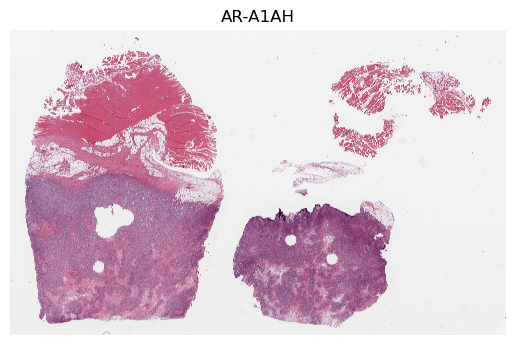

In [41]:
plt.imshow(slide)
plt.axis('off')
plt.title(case)

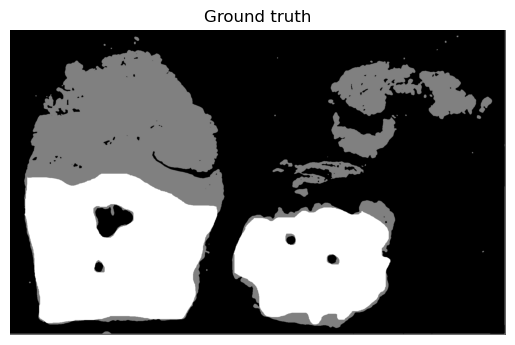

In [42]:
visualise_gt_classes(case)

In [43]:
patches, positions = image_to_patches_with_positions(slide, PATCH_SIZE, STRIDE)

In [44]:
patch_objects = get_patch_objects(patches, positions)

In [11]:
# Get trained model
# model_path = '../models/splendid-dawn-22_model_weights.pth' 
model_path = '/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/wandering-dust-71_model_weights.pth'
model = load_trained_model(num_classes, model_path)

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model = model.to(device)

In [46]:
# Set colourmap
# colourmap='plasma'
# colourmap='cool'
# colourmap='rainbow'
# colourmap='jet'
colourmap='coolwarm'

In [47]:
image_size = slide.shape

In [48]:
heatmap_probs, heatmap_classes = inference(image_size[0:2], patch_objects, model)

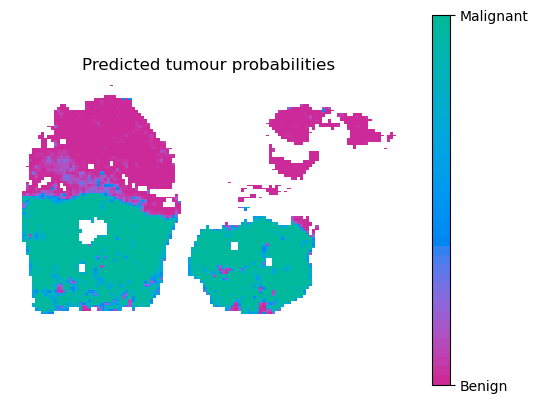

In [54]:
visualise_probabilities_map(heatmap_probs, colourmap=custom_pnk2gr)

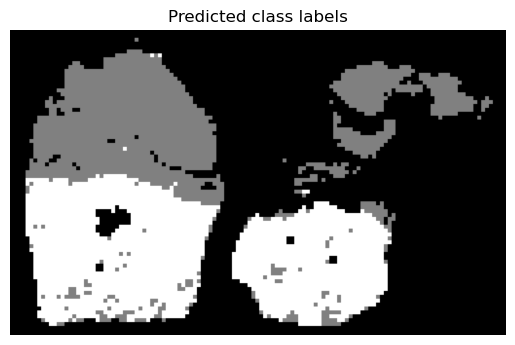

In [50]:
visualise_classification_map(heatmap_classes)

/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/site-packages/skimage/transform/_warps.py:674: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/alexandrasmith/miniforge3/envs/masters/lib/python3.8/site-packages/skimage/transform/_warps.py:678: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


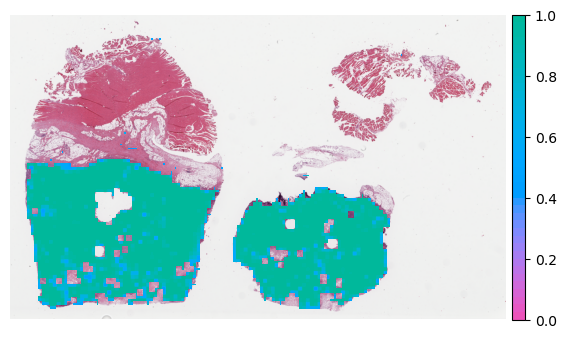

In [51]:
visualise_heatmap_over_image(sld, slide, heatmap_probs, colourmap=custom_pnk2gr)

In [ ]:
TP_map(heatmap_classes, labels, colourmap)

In [72]:
check_seg_accuracy('/Users/alexandrasmith/Desktop/', 'A2-A0SY', patch_objects, model)

torch.Size([5497])
Number of tissue tiles are 2059


(-0.5, 255.5, 255.5, -0.5)

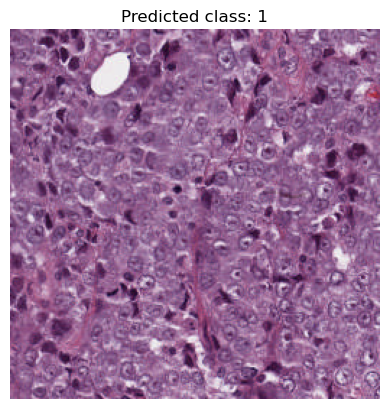

In [101]:
# Test one patch and its prediction
ex_patch = patch_objects[5085]
p1 = ex_patch.image
pred = ex_patch.prediction

plt.imshow(np.transpose(p1.numpy(), (1, 2, 0)))
plt.title(f"Predicted class: {pred}")
plt.axis('off')

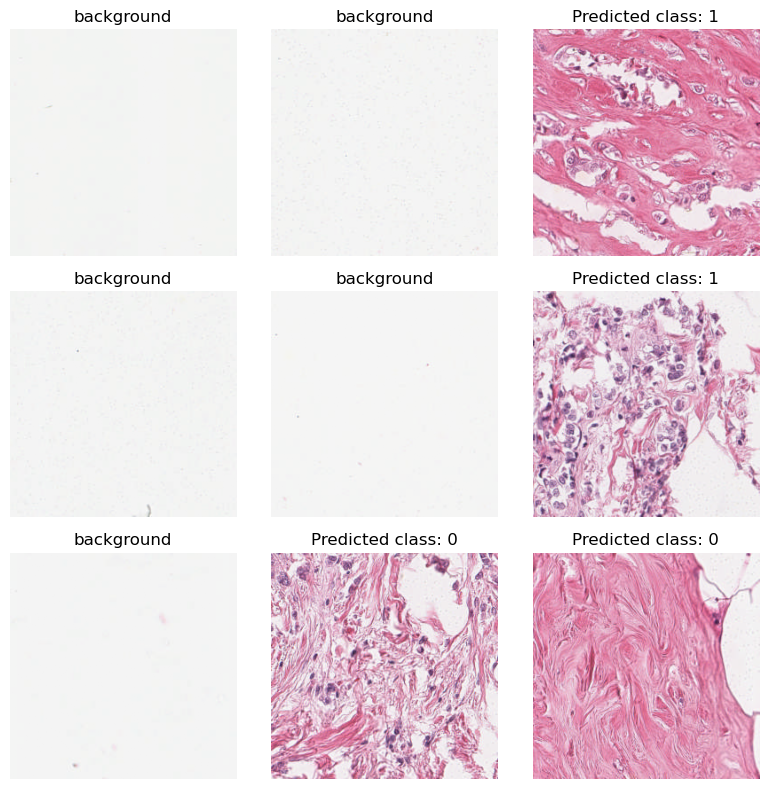

In [66]:
# Plot a few examples
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for ax in axes:
    patch = random.choice(patch_objects)
    image = patch.image
    pred = patch.prediction
    # pred = 'background' if pred == None else str(pred)
    title = f"Predicted class: {pred}" if pred != None else "background"
    ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# HER2 heatmaps

In [10]:
# MODEL 1

num_classes=2

model_path = '/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/wandering-dust-71_model_weights.pth'
model = load_trained_model(num_classes, model_path)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)

In [11]:
# MODEL 2
model2_path = '/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/bumbling-microwave-98_model_weights.pth'

model2 = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=num_classes)
model2.classif = nn.Sequential(
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.7),
    nn.Linear(model2.get_classifier().in_features, num_classes)
)

# Load the saved model state dict
model2.load_state_dict(torch.load(model2_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model2.eval()

InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [14]:
import json
# Read from datasplit.json file
file_path='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/models/data_splits/bumbling-microwave-98.json' # change
with open(file_path, 'r') as json_file:
    datasplit = json.load(json_file)
# Get cases used in testing split
cases_list=[]
for entry in datasplit['test']:
    e = entry.split('/')[-1]
    cases_list.append(e)

# load image
SEED=None
case, sld, slide = choose_random_image(cases_list, SEED)
image_size = slide.shape
print(case)

E2-A152


Text(0.5, 1.0, 'E2-A152')

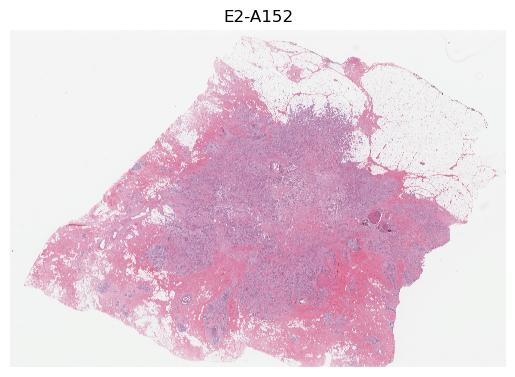

In [15]:
plt.imshow(slide)
plt.axis('off')
plt.title(case) #E2-A152

In [16]:
import pandas as pd
file_path = '/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/raw/HER2DataInfo.xlsx'
# file_path = '/home/21576262@su/masters/data/HER2DataInfo.xlsx'
df = pd.read_excel(file_path)

df.drop(df.index[-2:], inplace=True)

df['Case ID'] = df['Case ID'].str.replace('TCGA-','')
df['Case ID'] = df['Case ID'].str.replace('-01Z-00-DX1','')

df['Clinical.HER2.status'] = df['Clinical.HER2.status'].map({'Negative': 0, 'Positive': 1}).astype(int)

dict = df.set_index('Case ID').to_dict()['Clinical.HER2.status']

print(dict[case])

1


In [17]:
image_size = slide.shape
patches, positions = image_to_patches_with_positions(slide, PATCH_SIZE, STRIDE)
patch_objects = get_patch_objects(patches, positions)

In [18]:
heatmap_probs, heatmap_classes = her2_inference(image_size[0:2], patch_objects, model, model2)

In [19]:
print(heatmap_classes.shape)
print(heatmap_probs.shape)

(21982, 32368)
(21982, 32368)


In [20]:
# mask = np.argwhere(heatmap_classes==0)
# heatmap_probs[mask] = -1
classes = heatmap_classes.copy()
probs = heatmap_probs.copy()
values = np.where(classes == 0, -1, probs) # -1 for background and 0 class, probs only for tumour classes

In [21]:
values = np.where(values == -1, np.nan, values)

In [22]:
classes = classes.astype(float)
tissue = np.where(classes != 0, np.nan, 0.5)

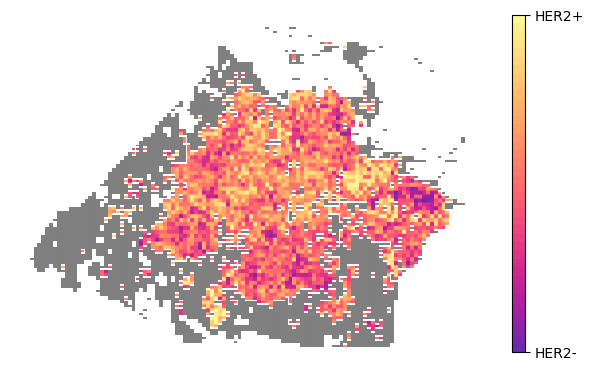

In [23]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(tissue, cmap="gray", vmin=0, vmax=1)
im = ax.imshow(values, cmap=custom_prpl2yel, vmin=0, vmax=1)
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
# plt.colorbar(im, cax=cax)
cbar = plt.colorbar(im, cax=cax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['HER2-', 'HER2+'])
plt.show()